# Deep Mean Shift Clustering

## Reqs

### Download

In [1]:
# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# !pip install pillow==4.1.1
# %reload_ext autoreload
# %autoreload
# !pip install python-mnist
# # !/usr/local/bin/python -m pip install visdom
# # !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip


### Import

In [2]:
import mnist
import pickle
import torch
import visdom
vis = visdom.Visdom(port='8097')
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable, Function, gradcheck

## Dataset

### Download

In [3]:
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor()])
root = '~/btp_mean_shift/content'
train = torchvision.datasets.MNIST(root, train=True, transform=trans, target_transform=None, download=True)
test = torchvision.datasets.MNIST(root, train=False, transform=trans, target_transform=None, download=True)

### Load

In [4]:
train_batch_size = 512
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=train_batch_size,
                 shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=test_batch_size,
                shuffle=False)

print ('total trainning batch number: '+ str(len(train_loader)))
print ('total testing batch number: '+ str(len(test_loader)))

total trainning batch number: 118
total testing batch number: 100


# AE Def

## Plotter

In [5]:
def plot_regen(model):

    for batch_idx, (x, target) in enumerate(train_loader):

        train_image = x
        break

    fig=plt.figure(figsize=(10,40))

    num_im = 4
    for i in range(num_im):
        data = np.array(train_image[i], dtype='float')
        data = data.reshape((28, 28))
        ax = fig.add_subplot(1, num_im, i+1)
        plt.imshow(data, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

    fig=plt.figure(figsize=(10,40))

    data = train_image.float()
    out, embed = model(data.cuda())
    out = out.cpu().detach().numpy()

    num_im = 4
    for i in range(num_im):
        out1 = out[i].reshape((28, 28))
        out1 = np.array(out1, dtype='float')
        
        ax = fig.add_subplot(1, num_im, i+1)
        plt.imshow(out1, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

# plot_regen(model)

## Mean Shift Cluster

In [6]:
class Mean_Shift_Cluster(torch.nn.Module):

    def __init__(self, delta, eta, ms_iter):
        super(Mean_Shift_Cluster, self).__init__()
        self.delta = delta
        self.eta = eta
        self.ms_iter = ms_iter

    def mean_shift_once(self, X):
        S = torch.mm(X.t(), X)
        K = torch.exp(self.delta * S)
        N = list(X.size())[1]
        d = torch.mm(K.t(), torch.ones(N, 1).cuda())
        q = 1 / d
        D_inv = torch.diagflat(q)
        eye = torch.eye(N).cuda()
        P = ((1-self.eta) * eye) + (self.eta * torch.mm(K, D_inv))
        return torch.mm(X, P)
  
    def forward(self, X):

        clust_embs = [0] * self.ms_iter

        clust_embs[0] = self.mean_shift_once(X)

        for it in range(1, self.ms_iter):
            clust_embs[it] = self.mean_shift_once(clust_embs[it-1])
    
        return clust_embs

## Loss

In [7]:
class Loss(torch.nn.Module):

    def __init__(self, alpha):
        super(Loss, self).__init__()
        self.alpha = alpha

    def cluster_loss(self, embeddings, y):

        num_classes = len(np.unique(y)) 
        num_samples_for_each_class = [0 for i in range(num_classes)] 
        for i in y:
            num_samples_for_each_class[int(i)] += 1

        total = len(y)
        loss_list = torch.zeros(total, total).cuda()
        cos_sim = torch.nn.CosineSimilarity(dim=0)

        for i in range(total):
            for j in range(i+1, total):
                w_i = 1 / num_samples_for_each_class[y[i]] 
                w_j = 1 / num_samples_for_each_class[y[j]]
                scale = embeddings[i].norm(p=2) * embeddings[j].norm(p=2)
                if y[i] == y[j]:
                    loss_list[i,j] = (w_i * w_j) * (1 - cos_sim(embeddings[i] , embeddings[j])) * scale  
                else:
                    loss_list[i,j] = (w_i * w_j) * (torch.clamp(cos_sim(embeddings[i] , embeddings[j]) - alpha , 0)) * scale

        return loss_list.sum()/total
  
    def regen_loss(self, x, x_):
    
        ae_loss = torch.nn.MSELoss()
        regen_loss = torch.sum(torch.mm((x-x_).view(1, -1), (x-x_).view(-1, 1)))/x.view(-1).size()[0]
        return regen_loss
    
    def forward(self, X, X_, embeddings, y):
    
        ms_loss = self.cluster_loss(embeddings[0].t(), y)
        for i in range(1, len(embeddings)):
            ms_loss = ms_loss + self.cluster_loss(embeddings[i].t(), y)
            
        ae_loss = self.regen_loss(X, X_)

        return ms_loss + ae_loss, ms_loss, ae_loss

## Weigh init

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)


## Model

In [9]:
class AE(nn.Module):
    def __init__(self, z_len):
        super(AE, self).__init__()

        self.conv_1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.ind1 = 0
        self.ind2 = 0
        self.conv_2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(4*4*50, 500)
        self.fc_2 = nn.Linear(500,z_len)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.upfc_1 = nn.Linear(z_len, 500)
        self.upfc_2 = nn.Linear(500, 4*4*50)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.upconv_1 = nn.ConvTranspose2d(50, 20, kernel_size=5, stride=1)
        self.upconv_2 = nn.ConvTranspose2d(20, 1, kernel_size=5, stride=1)  

    def encode(self, x):
        z = self.conv_1(x)
        z = self.relu(z)
        z, self.ind1 = self.pool(z)
        z = self.conv_2(z)
        z = self.relu(z)
        z, self.ind2 = self.pool(z)
        z = z.view(z.size(0), -1)
        z = self.fc_1(z)
        z = self.relu(z)
        z = self.fc_2(z)
        z_norm = z.norm(p=2, dim=1, keepdim=True).detach()
        z = z.div(z_norm.expand_as(z))
        return z

#     def mean_shift_cluster(self, X, delta, eta):
#         S = torch.mm(X.t(), X)
#         K = torch.exp(delta * S)
#         N = list(X.size())[1]
#         d = torch.mm(K.t(), torch.ones(N, 1).cuda())
#         q = 1 / d
#         D_inv = torch.diagflat(q)
#         eye = torch.eye(N).cuda()
#         P = ((1-eta) * eye) + (eta * torch.mm(K, D_inv))
#         return torch.mm(X, P)

    def decode(self, z):
        x = self.upfc_1(z)
        x = self.relu(x)
        x = self.upfc_2(x)
        x = x.view(x.size(0), 50, 4, 4)
        x = self.unpool(x, self.ind2)
        x = self.relu(x)
        x = self.upconv_1(x)
        x = self.unpool(x, self.ind1)
        x = self.relu(x)
        x = self.upconv_2(x)
        x = self.sigmoid(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_ = self.decode(z)
        return x_, z

# Model Init

## Params

In [10]:
alpha = 0.5 
eta = 1 
ms_iter = 3
delta = 3 / (1-alpha)
total_epochs = 150
embedding_dim = 64

## Init

In [11]:
model = AE(embedding_dim)
model.apply(weights_init)
model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.SGD(model.parameters())
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

ms_clust = Mean_Shift_Cluster(delta, eta, ms_iter)

ms_ae_loss = Loss(alpha)
# new_loss = torch.nn.BCELoss(reduce=False)

# Train

epoch 0
epoch 0 batch 0 batch total loss 0.35457343
epoch 0 batch 0 batch cluster loss 0.12469852
epoch 0 batch 0 batch regen loss 0.2298749
saving...



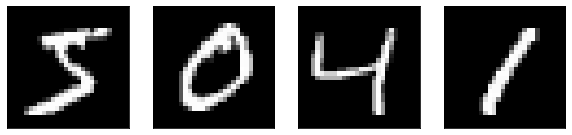

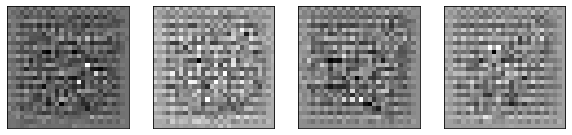

epoch 0 batch 1 batch total loss 0.35224518
epoch 0 batch 1 batch cluster loss 0.12296827
epoch 0 batch 1 batch regen loss 0.22927691
epoch 0 batch 2 batch total loss 0.3461815
epoch 0 batch 2 batch cluster loss 0.11716068
epoch 0 batch 2 batch regen loss 0.22902082
epoch 0 batch 3 batch total loss 0.32013178
epoch 0 batch 3 batch cluster loss 0.09203345
epoch 0 batch 3 batch regen loss 0.22809833
epoch 0 batch 4 batch total loss 0.27765045
epoch 0 batch 4 batch cluster loss 0.051208965
epoch 0 batch 4 batch regen loss 0.22644147
epoch 0 batch 5 batch total loss 0.31477022
epoch 0 batch 5 batch cluster loss 0.0899203
epoch 0 batch 5 batch regen loss 0.22484991
saving...



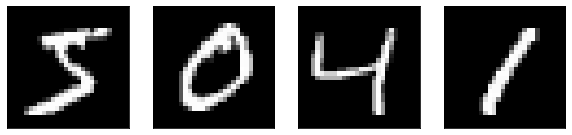

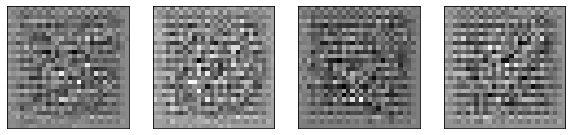

epoch 0 batch 6 batch total loss 0.3201635
epoch 0 batch 6 batch cluster loss 0.09640436
epoch 0 batch 6 batch regen loss 0.22375914
epoch 0 batch 7 batch total loss 0.30306044
epoch 0 batch 7 batch cluster loss 0.08173057
epoch 0 batch 7 batch regen loss 0.22132988
epoch 0 batch 8 batch total loss 0.25897786
epoch 0 batch 8 batch cluster loss 0.038900595
epoch 0 batch 8 batch regen loss 0.22007726
epoch 0 batch 9 batch total loss 0.28562817
epoch 0 batch 9 batch cluster loss 0.06753399
epoch 0 batch 9 batch regen loss 0.21809418
epoch 0 batch 10 batch total loss 0.30103755
epoch 0 batch 10 batch cluster loss 0.085176274
epoch 0 batch 10 batch regen loss 0.21586128
saving...



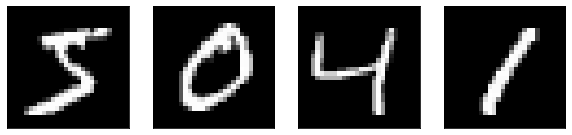

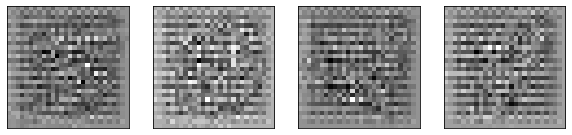

epoch 0 batch 11 batch total loss 0.2796232
epoch 0 batch 11 batch cluster loss 0.065293804
epoch 0 batch 11 batch regen loss 0.2143294
epoch 0 batch 12 batch total loss 0.24886006
epoch 0 batch 12 batch cluster loss 0.036644008
epoch 0 batch 12 batch regen loss 0.21221605
epoch 0 batch 13 batch total loss 0.2831814
epoch 0 batch 13 batch cluster loss 0.07442197
epoch 0 batch 13 batch regen loss 0.20875943
epoch 0 batch 14 batch total loss 0.2705948
epoch 0 batch 14 batch cluster loss 0.06480276
epoch 0 batch 14 batch regen loss 0.20579205
epoch 0 batch 15 batch total loss 0.24371484
epoch 0 batch 15 batch cluster loss 0.0388306
epoch 0 batch 15 batch regen loss 0.20488423
saving...



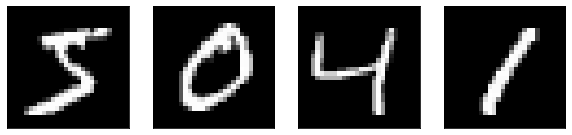

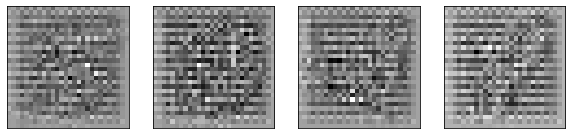

epoch 0 batch 16 batch total loss 0.27005246
epoch 0 batch 16 batch cluster loss 0.066427216
epoch 0 batch 16 batch regen loss 0.20362525
epoch 0 batch 17 batch total loss 0.23937942
epoch 0 batch 17 batch cluster loss 0.039820533
epoch 0 batch 17 batch regen loss 0.19955888
epoch 0 batch 18 batch total loss 0.26860458
epoch 0 batch 18 batch cluster loss 0.07123333
epoch 0 batch 18 batch regen loss 0.19737126
epoch 0 batch 19 batch total loss 0.27249724
epoch 0 batch 19 batch cluster loss 0.07739525
epoch 0 batch 19 batch regen loss 0.19510199
epoch 0 batch 20 batch total loss 0.21923353
epoch 0 batch 20 batch cluster loss 0.025438001
epoch 0 batch 20 batch regen loss 0.19379553
saving...



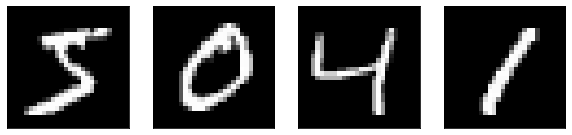

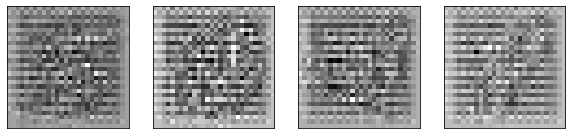

epoch 0 batch 21 batch total loss 0.26052296
epoch 0 batch 21 batch cluster loss 0.069139585
epoch 0 batch 21 batch regen loss 0.19138336
epoch 0 batch 22 batch total loss 0.22089735
epoch 0 batch 22 batch cluster loss 0.032478787
epoch 0 batch 22 batch regen loss 0.18841855
epoch 0 batch 23 batch total loss 0.26852265
epoch 0 batch 23 batch cluster loss 0.081751384
epoch 0 batch 23 batch regen loss 0.18677127
epoch 0 batch 24 batch total loss 0.26516688
epoch 0 batch 24 batch cluster loss 0.08135329
epoch 0 batch 24 batch regen loss 0.1838136
epoch 0 batch 25 batch total loss 0.23970014
epoch 0 batch 25 batch cluster loss 0.057063185
epoch 0 batch 25 batch regen loss 0.18263696
saving...



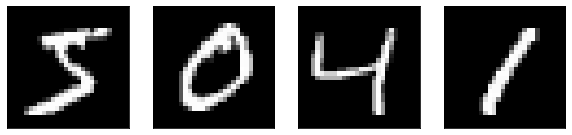

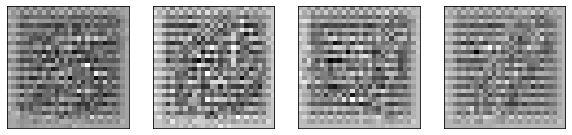

epoch 0 batch 26 batch total loss 0.26373518
epoch 0 batch 26 batch cluster loss 0.084356345
epoch 0 batch 26 batch regen loss 0.17937882
epoch 0 batch 27 batch total loss 0.2592911
epoch 0 batch 27 batch cluster loss 0.08062483
epoch 0 batch 27 batch regen loss 0.17866626
epoch 0 batch 28 batch total loss 0.24336529
epoch 0 batch 28 batch cluster loss 0.06887967
epoch 0 batch 28 batch regen loss 0.17448561
epoch 0 batch 29 batch total loss 0.23866838
epoch 0 batch 29 batch cluster loss 0.067022316
epoch 0 batch 29 batch regen loss 0.17164607
epoch 0 batch 30 batch total loss 0.22283202
epoch 0 batch 30 batch cluster loss 0.053784214
epoch 0 batch 30 batch regen loss 0.1690478
saving...



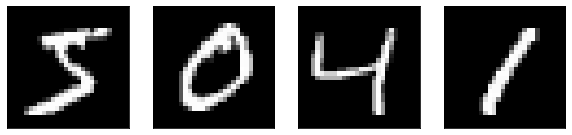

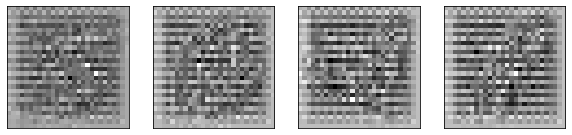

epoch 0 batch 31 batch total loss 0.2742558
epoch 0 batch 31 batch cluster loss 0.10386123
epoch 0 batch 31 batch regen loss 0.1703946
epoch 0 batch 32 batch total loss 0.272188
epoch 0 batch 32 batch cluster loss 0.106564656
epoch 0 batch 32 batch regen loss 0.16562335
epoch 0 batch 33 batch total loss 0.19483316
epoch 0 batch 33 batch cluster loss 0.029534576
epoch 0 batch 33 batch regen loss 0.16529858
epoch 0 batch 34 batch total loss 0.27874866
epoch 0 batch 34 batch cluster loss 0.11769839
epoch 0 batch 34 batch regen loss 0.16105027
epoch 0 batch 35 batch total loss 0.28624624
epoch 0 batch 35 batch cluster loss 0.12444919
epoch 0 batch 35 batch regen loss 0.16179705
saving...



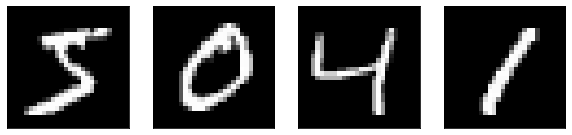

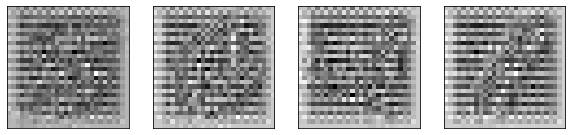

epoch 0 batch 36 batch total loss 0.28364596
epoch 0 batch 36 batch cluster loss 0.124765806
epoch 0 batch 36 batch regen loss 0.15888016
epoch 0 batch 37 batch total loss 0.27922225
epoch 0 batch 37 batch cluster loss 0.12035729
epoch 0 batch 37 batch regen loss 0.15886497
epoch 0 batch 38 batch total loss 0.21974285
epoch 0 batch 38 batch cluster loss 0.05938792
epoch 0 batch 38 batch regen loss 0.16035493
epoch 0 batch 39 batch total loss 0.27985892
epoch 0 batch 39 batch cluster loss 0.12433721
epoch 0 batch 39 batch regen loss 0.1555217
epoch 0 batch 40 batch total loss 0.28436726
epoch 0 batch 40 batch cluster loss 0.12953095
epoch 0 batch 40 batch regen loss 0.15483633
saving...



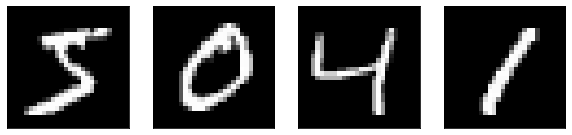

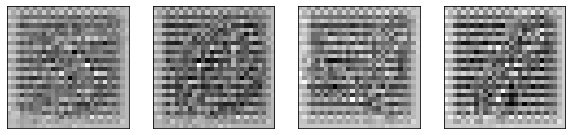

epoch 0 batch 41 batch total loss 0.2820349
epoch 0 batch 41 batch cluster loss 0.13045892
epoch 0 batch 41 batch regen loss 0.15157598
epoch 0 batch 42 batch total loss 0.28322595
epoch 0 batch 42 batch cluster loss 0.13079348
epoch 0 batch 42 batch regen loss 0.15243247
epoch 0 batch 43 batch total loss 0.2792629
epoch 0 batch 43 batch cluster loss 0.13087688
epoch 0 batch 43 batch regen loss 0.14838603
epoch 0 batch 44 batch total loss 0.28303337
epoch 0 batch 44 batch cluster loss 0.13088393
epoch 0 batch 44 batch regen loss 0.15214945
epoch 0 batch 45 batch total loss 0.27967495
epoch 0 batch 45 batch cluster loss 0.13077022
epoch 0 batch 45 batch regen loss 0.14890474
saving...



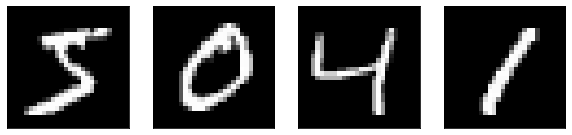

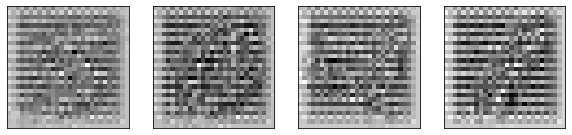

epoch 0 batch 47 batch total loss 0.27410215
epoch 0 batch 47 batch cluster loss 0.12965201
epoch 0 batch 47 batch regen loss 0.14445014
epoch 0 batch 48 batch total loss 0.2701039
epoch 0 batch 48 batch cluster loss 0.12722066
epoch 0 batch 48 batch regen loss 0.14288324
epoch 0 batch 49 batch total loss 0.24132484
epoch 0 batch 49 batch cluster loss 0.09684296
epoch 0 batch 49 batch regen loss 0.14448188
epoch 0 batch 50 batch total loss 0.2646879
epoch 0 batch 50 batch cluster loss 0.1256821
epoch 0 batch 50 batch regen loss 0.1390058
saving...



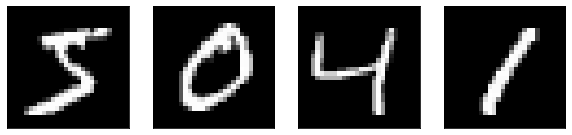

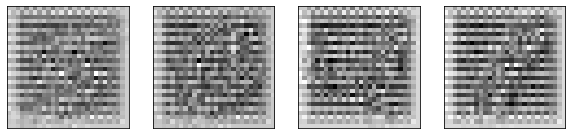

epoch 0 batch 51 batch total loss 0.26646984
epoch 0 batch 51 batch cluster loss 0.13003372
epoch 0 batch 51 batch regen loss 0.1364361
epoch 0 batch 52 batch total loss 0.2697209
epoch 0 batch 52 batch cluster loss 0.13077417
epoch 0 batch 52 batch regen loss 0.13894673
epoch 0 batch 53 batch total loss 0.26865488
epoch 0 batch 53 batch cluster loss 0.13107209
epoch 0 batch 53 batch regen loss 0.13758281
epoch 0 batch 54 batch total loss 0.26790297
epoch 0 batch 54 batch cluster loss 0.13123024
epoch 0 batch 54 batch regen loss 0.13667274
epoch 0 batch 55 batch total loss 0.27162743
epoch 0 batch 55 batch cluster loss 0.1312806
epoch 0 batch 55 batch regen loss 0.14034684
saving...



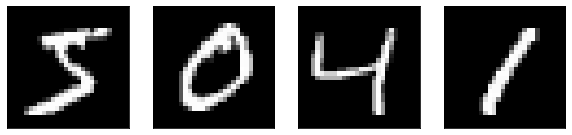

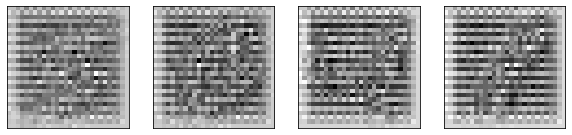

epoch 0 batch 56 batch total loss 0.2652365
epoch 0 batch 56 batch cluster loss 0.13130005
epoch 0 batch 56 batch regen loss 0.13393646
epoch 0 batch 57 batch total loss 0.2669317
epoch 0 batch 57 batch cluster loss 0.13131526
epoch 0 batch 57 batch regen loss 0.13561644
epoch 0 batch 58 batch total loss 0.25983745
epoch 0 batch 58 batch cluster loss 0.13129652
epoch 0 batch 58 batch regen loss 0.12854095
epoch 0 batch 59 batch total loss 0.2605952
epoch 0 batch 59 batch cluster loss 0.13121174
epoch 0 batch 59 batch regen loss 0.12938347
epoch 0 batch 60 batch total loss 0.25907302
epoch 0 batch 60 batch cluster loss 0.13110788
epoch 0 batch 60 batch regen loss 0.12796512
saving...



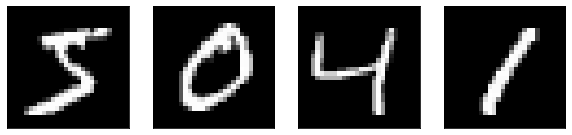

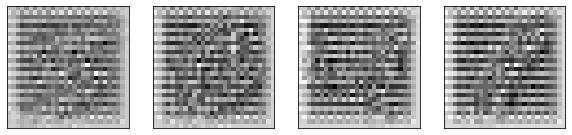

epoch 0 batch 61 batch total loss 0.25625333
epoch 0 batch 61 batch cluster loss 0.1309349
epoch 0 batch 61 batch regen loss 0.12531844
epoch 0 batch 62 batch total loss 0.2594109
epoch 0 batch 62 batch cluster loss 0.13043617
epoch 0 batch 62 batch regen loss 0.12897472
epoch 0 batch 63 batch total loss 0.25902066
epoch 0 batch 63 batch cluster loss 0.12928595
epoch 0 batch 63 batch regen loss 0.12973471
epoch 0 batch 64 batch total loss 0.25130972
epoch 0 batch 64 batch cluster loss 0.12237642
epoch 0 batch 64 batch regen loss 0.1289333
epoch 0 batch 65 batch total loss 0.22546434
epoch 0 batch 65 batch cluster loss 0.101458505
epoch 0 batch 65 batch regen loss 0.12400583
saving...



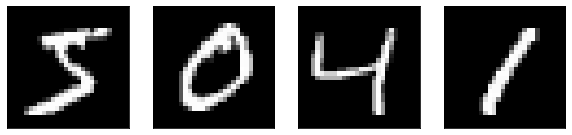

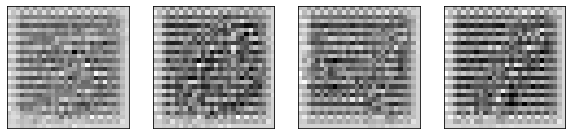

epoch 0 batch 66 batch total loss 0.24564707
epoch 0 batch 66 batch cluster loss 0.119779915
epoch 0 batch 66 batch regen loss 0.12586716
epoch 0 batch 67 batch total loss 0.23014316
epoch 0 batch 67 batch cluster loss 0.10302675
epoch 0 batch 67 batch regen loss 0.12711641
epoch 0 batch 68 batch total loss 0.244551
epoch 0 batch 68 batch cluster loss 0.12023921
epoch 0 batch 68 batch regen loss 0.1243118
epoch 0 batch 69 batch total loss 0.2514369
epoch 0 batch 69 batch cluster loss 0.12674385
epoch 0 batch 69 batch regen loss 0.12469303
epoch 0 batch 70 batch total loss 0.25032264
epoch 0 batch 70 batch cluster loss 0.12668337
epoch 0 batch 70 batch regen loss 0.123639286
saving...



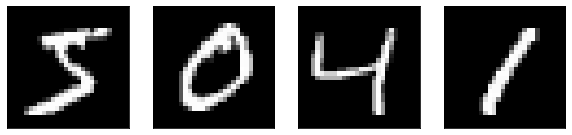

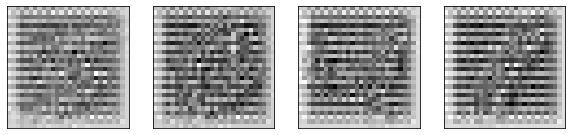

epoch 0 batch 71 batch total loss 0.24707982
epoch 0 batch 71 batch cluster loss 0.11858487
epoch 0 batch 71 batch regen loss 0.12849495
epoch 0 batch 72 batch total loss 0.23533
epoch 0 batch 72 batch cluster loss 0.108054146
epoch 0 batch 72 batch regen loss 0.12727585
epoch 0 batch 73 batch total loss 0.23562685
epoch 0 batch 73 batch cluster loss 0.114629075
epoch 0 batch 73 batch regen loss 0.12099778
epoch 0 batch 74 batch total loss 0.16264299
epoch 0 batch 74 batch cluster loss 0.04238832
epoch 0 batch 74 batch regen loss 0.12025466
epoch 0 batch 75 batch total loss 0.24127376
epoch 0 batch 75 batch cluster loss 0.12047371
epoch 0 batch 75 batch regen loss 0.12080005
saving...



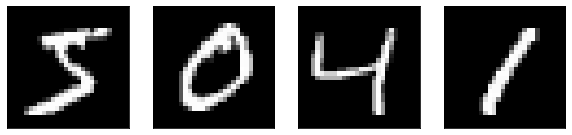

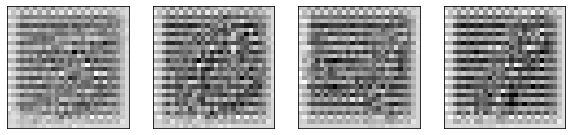

epoch 0 batch 76 batch total loss 0.24509217
epoch 0 batch 76 batch cluster loss 0.122032315
epoch 0 batch 76 batch regen loss 0.123059854
epoch 0 batch 77 batch total loss 0.178081
epoch 0 batch 77 batch cluster loss 0.059235916
epoch 0 batch 77 batch regen loss 0.11884509
epoch 0 batch 78 batch total loss 0.24874675
epoch 0 batch 78 batch cluster loss 0.12925805
epoch 0 batch 78 batch regen loss 0.119488694
epoch 0 batch 79 batch total loss 0.24979305
epoch 0 batch 79 batch cluster loss 0.13101843
epoch 0 batch 79 batch regen loss 0.118774615
epoch 0 batch 80 batch total loss 0.24867888
epoch 0 batch 80 batch cluster loss 0.13137433
epoch 0 batch 80 batch regen loss 0.11730455
saving...



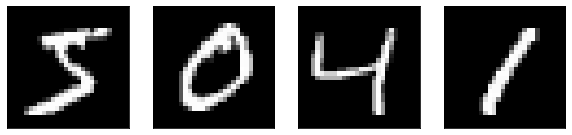

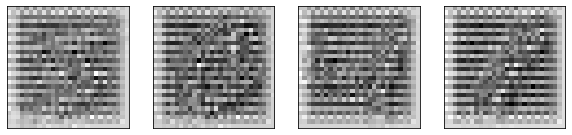

epoch 0 batch 81 batch total loss 0.24600042
epoch 0 batch 81 batch cluster loss 0.1315256
epoch 0 batch 81 batch regen loss 0.11447482
epoch 0 batch 82 batch total loss 0.2513348
epoch 0 batch 82 batch cluster loss 0.13155402
epoch 0 batch 82 batch regen loss 0.11978075
epoch 0 batch 83 batch total loss 0.25072998
epoch 0 batch 83 batch cluster loss 0.13159078
epoch 0 batch 83 batch regen loss 0.119139194
epoch 0 batch 84 batch total loss 0.24835473
epoch 0 batch 84 batch cluster loss 0.13161989
epoch 0 batch 84 batch regen loss 0.116734855
epoch 0 batch 85 batch total loss 0.2453892
epoch 0 batch 85 batch cluster loss 0.1316279
epoch 0 batch 85 batch regen loss 0.1137613
saving...



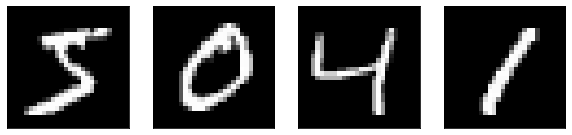

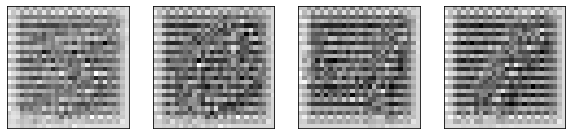

epoch 0 batch 86 batch total loss 0.24549079
epoch 0 batch 86 batch cluster loss 0.13163117
epoch 0 batch 86 batch regen loss 0.11385963
epoch 0 batch 87 batch total loss 0.2451634
epoch 0 batch 87 batch cluster loss 0.13160732
epoch 0 batch 87 batch regen loss 0.11355607
epoch 0 batch 88 batch total loss 0.24487272
epoch 0 batch 88 batch cluster loss 0.13158996
epoch 0 batch 88 batch regen loss 0.11328276
epoch 0 batch 89 batch total loss 0.24158084
epoch 0 batch 89 batch cluster loss 0.13158894
epoch 0 batch 89 batch regen loss 0.109991916
epoch 0 batch 90 batch total loss 0.24307162
epoch 0 batch 90 batch cluster loss 0.13152745
epoch 0 batch 90 batch regen loss 0.11154416
saving...



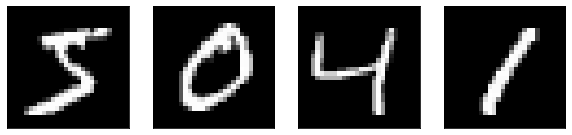

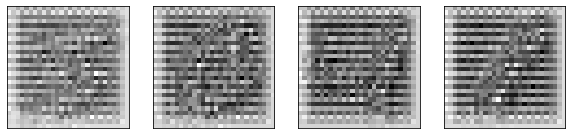

epoch 0 batch 91 batch total loss 0.247573
epoch 0 batch 91 batch cluster loss 0.13142675
epoch 0 batch 91 batch regen loss 0.11614625
epoch 0 batch 92 batch total loss 0.24408412
epoch 0 batch 92 batch cluster loss 0.13131997
epoch 0 batch 92 batch regen loss 0.11276414
epoch 0 batch 93 batch total loss 0.24982539
epoch 0 batch 93 batch cluster loss 0.13099673
epoch 0 batch 93 batch regen loss 0.11882866
epoch 0 batch 94 batch total loss 0.24965696
epoch 0 batch 94 batch cluster loss 0.13017492
epoch 0 batch 94 batch regen loss 0.11948204
epoch 0 batch 95 batch total loss 0.23619336
epoch 0 batch 95 batch cluster loss 0.12422357
epoch 0 batch 95 batch regen loss 0.11196979
saving...



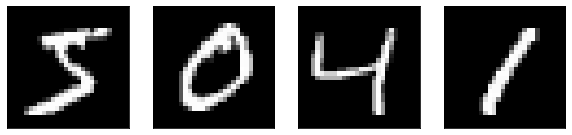

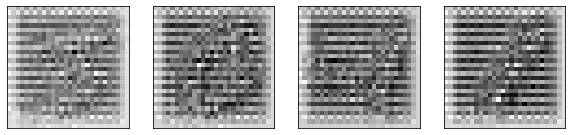

epoch 0 batch 96 batch total loss 0.23628357
epoch 0 batch 96 batch cluster loss 0.12422715
epoch 0 batch 96 batch regen loss 0.11205642
epoch 0 batch 97 batch total loss 0.23893441
epoch 0 batch 97 batch cluster loss 0.12980542
epoch 0 batch 97 batch regen loss 0.109129
epoch 0 batch 98 batch total loss 0.23932001
epoch 0 batch 98 batch cluster loss 0.13038617
epoch 0 batch 98 batch regen loss 0.10893384
epoch 0 batch 99 batch total loss 0.24361423
epoch 0 batch 99 batch cluster loss 0.13045657
epoch 0 batch 99 batch regen loss 0.11315765
epoch 0 batch 100 batch total loss 0.24369754
epoch 0 batch 100 batch cluster loss 0.12994558
epoch 0 batch 100 batch regen loss 0.11375196
saving...



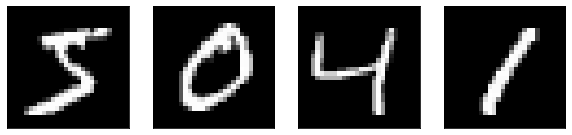

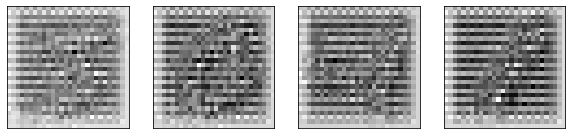

epoch 0 batch 101 batch total loss 0.23341745
epoch 0 batch 101 batch cluster loss 0.12752198
epoch 0 batch 101 batch regen loss 0.10589547
epoch 0 batch 102 batch total loss 0.1545559
epoch 0 batch 102 batch cluster loss 0.045238182
epoch 0 batch 102 batch regen loss 0.10931772
epoch 0 batch 103 batch total loss 0.23987687
epoch 0 batch 103 batch cluster loss 0.12879604
epoch 0 batch 103 batch regen loss 0.11108083
epoch 0 batch 104 batch total loss 0.23702288
epoch 0 batch 104 batch cluster loss 0.13047297
epoch 0 batch 104 batch regen loss 0.106549904
epoch 0 batch 105 batch total loss 0.23784858
epoch 0 batch 105 batch cluster loss 0.13083182
epoch 0 batch 105 batch regen loss 0.10701676
saving...



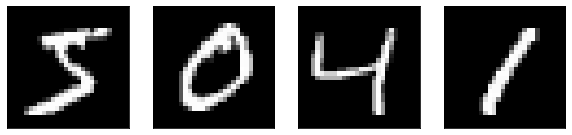

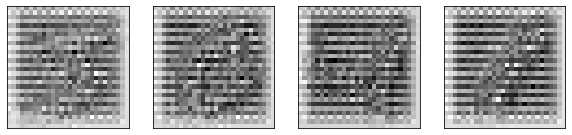

epoch 0 batch 106 batch total loss 0.24299805
epoch 0 batch 106 batch cluster loss 0.13083334
epoch 0 batch 106 batch regen loss 0.112164706
epoch 0 batch 107 batch total loss 0.24070509
epoch 0 batch 107 batch cluster loss 0.13064289
epoch 0 batch 107 batch regen loss 0.1100622
epoch 0 batch 108 batch total loss 0.24406955
epoch 0 batch 108 batch cluster loss 0.13000113
epoch 0 batch 108 batch regen loss 0.11406841
epoch 0 batch 109 batch total loss 0.23695572
epoch 0 batch 109 batch cluster loss 0.12797405
epoch 0 batch 109 batch regen loss 0.10898167
epoch 0 batch 110 batch total loss 0.16735342
epoch 0 batch 110 batch cluster loss 0.059717968
epoch 0 batch 110 batch regen loss 0.10763545
saving...



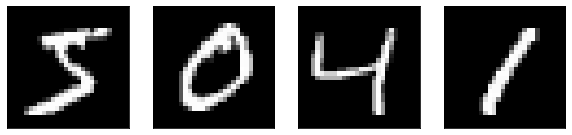

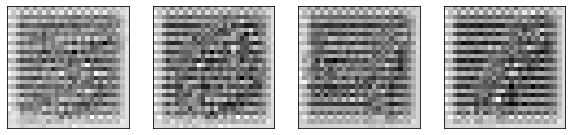

epoch 0 batch 111 batch total loss 0.23556037
epoch 0 batch 111 batch cluster loss 0.13057232
epoch 0 batch 111 batch regen loss 0.10498805
epoch 0 batch 112 batch total loss 0.23607841
epoch 0 batch 112 batch cluster loss 0.13142027
epoch 0 batch 112 batch regen loss 0.10465814
epoch 0 batch 113 batch total loss 0.2361339
epoch 0 batch 113 batch cluster loss 0.13158649
epoch 0 batch 113 batch regen loss 0.104547404
epoch 0 batch 114 batch total loss 0.2343551
epoch 0 batch 114 batch cluster loss 0.13164556
epoch 0 batch 114 batch regen loss 0.10270955
epoch 0 batch 115 batch total loss 0.24287313
epoch 0 batch 115 batch cluster loss 0.13168374
epoch 0 batch 115 batch regen loss 0.111189395
saving...



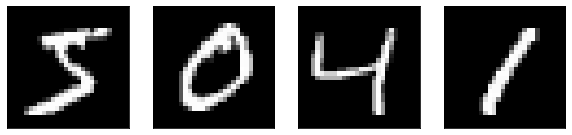

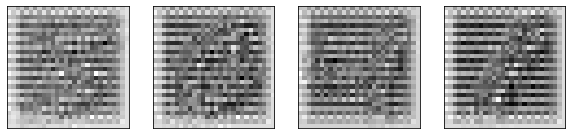

epoch 0 batch 116 batch total loss 0.2474056
epoch 0 batch 116 batch cluster loss 0.13170646
epoch 0 batch 116 batch regen loss 0.11569914
epoch 0 batch 117 batch total loss 0.8001695
epoch 0 batch 117 batch cluster loss 0.7027449
epoch 0 batch 117 batch regen loss 0.09742465

epoch 0 epoch avg loss 0.25998489344019
epoch 0 epoch avg cluster loss 0.11313103009962429
epoch 0 epoch avg regen loss 0.14685386431924366



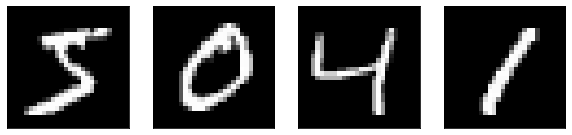

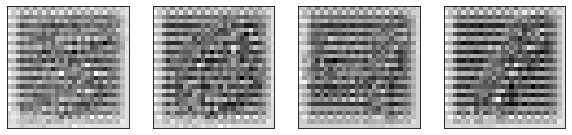

saving...

epoch 1
epoch 1 batch 0 batch total loss 0.23666836
epoch 1 batch 0 batch cluster loss 0.13172033
epoch 1 batch 0 batch regen loss 0.10494803
saving...



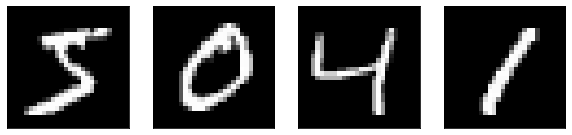

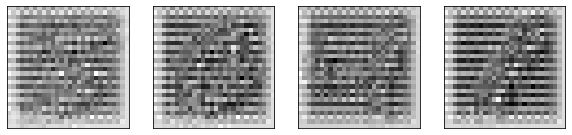

epoch 1 batch 1 batch total loss 0.23849323
epoch 1 batch 1 batch cluster loss 0.13173583
epoch 1 batch 1 batch regen loss 0.1067574
epoch 1 batch 2 batch total loss 0.24211213
epoch 1 batch 2 batch cluster loss 0.13173532
epoch 1 batch 2 batch regen loss 0.110376805
epoch 1 batch 3 batch total loss 0.23853838
epoch 1 batch 3 batch cluster loss 0.13173422
epoch 1 batch 3 batch regen loss 0.10680416
epoch 1 batch 4 batch total loss 0.23898813
epoch 1 batch 4 batch cluster loss 0.13173513
epoch 1 batch 4 batch regen loss 0.10725299
epoch 1 batch 5 batch total loss 0.23807347
epoch 1 batch 5 batch cluster loss 0.1317329
epoch 1 batch 5 batch regen loss 0.106340565
saving...



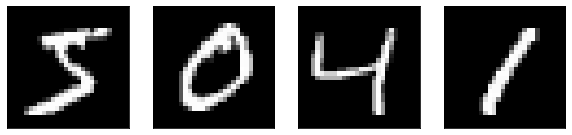

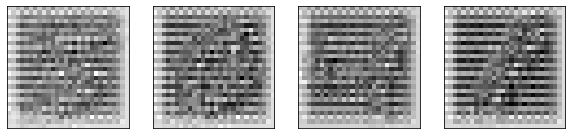

epoch 1 batch 6 batch total loss 0.23343572
epoch 1 batch 6 batch cluster loss 0.1317369
epoch 1 batch 6 batch regen loss 0.10169881
epoch 1 batch 7 batch total loss 0.2376073
epoch 1 batch 7 batch cluster loss 0.1317367
epoch 1 batch 7 batch regen loss 0.1058706
epoch 1 batch 8 batch total loss 0.23681909
epoch 1 batch 8 batch cluster loss 0.1317356
epoch 1 batch 8 batch regen loss 0.1050835
epoch 1 batch 9 batch total loss 0.24128485
epoch 1 batch 9 batch cluster loss 0.13171712
epoch 1 batch 9 batch regen loss 0.10956774
epoch 1 batch 10 batch total loss 0.24265307
epoch 1 batch 10 batch cluster loss 0.13173845
epoch 1 batch 10 batch regen loss 0.11091462
saving...



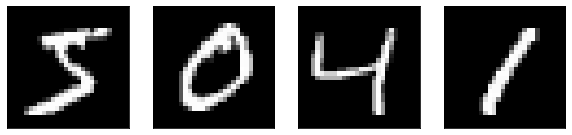

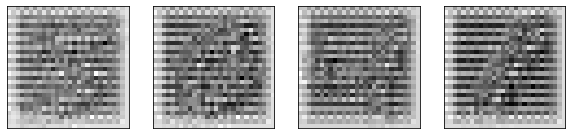

epoch 1 batch 11 batch total loss 0.24284245
epoch 1 batch 11 batch cluster loss 0.13172719
epoch 1 batch 11 batch regen loss 0.11111526
epoch 1 batch 12 batch total loss 0.2412318
epoch 1 batch 12 batch cluster loss 0.13171431
epoch 1 batch 12 batch regen loss 0.10951748
epoch 1 batch 13 batch total loss 0.23176172
epoch 1 batch 13 batch cluster loss 0.13171886
epoch 1 batch 13 batch regen loss 0.10004286
epoch 1 batch 14 batch total loss 0.228182
epoch 1 batch 14 batch cluster loss 0.13171668
epoch 1 batch 14 batch regen loss 0.09646532
epoch 1 batch 15 batch total loss 0.23898745
epoch 1 batch 15 batch cluster loss 0.13170092
epoch 1 batch 15 batch regen loss 0.107286535
saving...



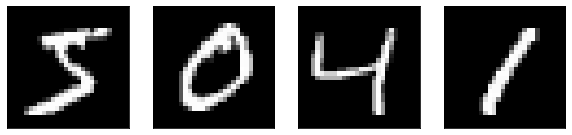

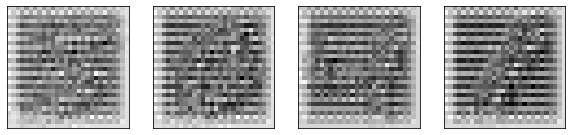

epoch 1 batch 16 batch total loss 0.24390104
epoch 1 batch 16 batch cluster loss 0.1316813
epoch 1 batch 16 batch regen loss 0.11221976
epoch 1 batch 17 batch total loss 0.23454614
epoch 1 batch 17 batch cluster loss 0.13167268
epoch 1 batch 17 batch regen loss 0.10287346
epoch 1 batch 18 batch total loss 0.23629883
epoch 1 batch 18 batch cluster loss 0.13164246
epoch 1 batch 18 batch regen loss 0.10465636
epoch 1 batch 19 batch total loss 0.23742765
epoch 1 batch 19 batch cluster loss 0.13163501
epoch 1 batch 19 batch regen loss 0.105792634
epoch 1 batch 20 batch total loss 0.24211128
epoch 1 batch 20 batch cluster loss 0.13159095
epoch 1 batch 20 batch regen loss 0.11052033
saving...



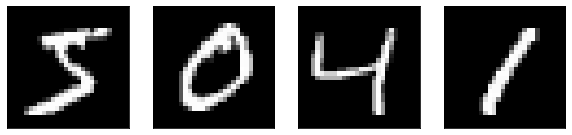

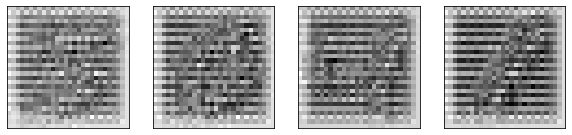

epoch 1 batch 21 batch total loss 0.23961079
epoch 1 batch 21 batch cluster loss 0.13154477
epoch 1 batch 21 batch regen loss 0.10806603
epoch 1 batch 22 batch total loss 0.23491275
epoch 1 batch 22 batch cluster loss 0.13145736
epoch 1 batch 22 batch regen loss 0.10345539
epoch 1 batch 23 batch total loss 0.23850945
epoch 1 batch 23 batch cluster loss 0.1313649
epoch 1 batch 23 batch regen loss 0.10714456
epoch 1 batch 24 batch total loss 0.23799318
epoch 1 batch 24 batch cluster loss 0.1311749
epoch 1 batch 24 batch regen loss 0.106818266
epoch 1 batch 25 batch total loss 0.24058576
epoch 1 batch 25 batch cluster loss 0.13088575
epoch 1 batch 25 batch regen loss 0.10970001
saving...



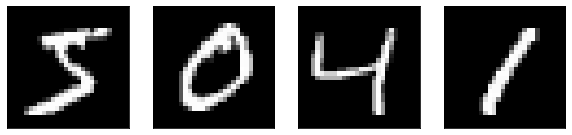

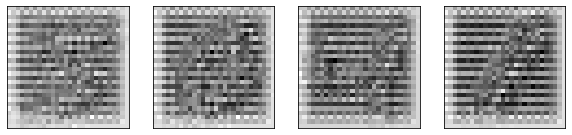

epoch 1 batch 26 batch total loss 0.23484644
epoch 1 batch 26 batch cluster loss 0.13007915
epoch 1 batch 26 batch regen loss 0.10476729
epoch 1 batch 27 batch total loss 0.2365576
epoch 1 batch 27 batch cluster loss 0.12735704
epoch 1 batch 27 batch regen loss 0.10920056
epoch 1 batch 28 batch total loss 0.20886186
epoch 1 batch 28 batch cluster loss 0.106958956
epoch 1 batch 28 batch regen loss 0.10190291
epoch 1 batch 29 batch total loss 0.21624836
epoch 1 batch 29 batch cluster loss 0.11732492
epoch 1 batch 29 batch regen loss 0.098923445
epoch 1 batch 30 batch total loss 0.2259725
epoch 1 batch 30 batch cluster loss 0.1274397
epoch 1 batch 30 batch regen loss 0.09853281
saving...



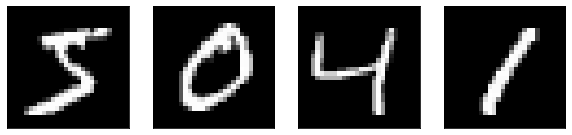

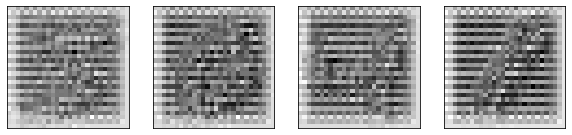

epoch 1 batch 31 batch total loss 0.23518577
epoch 1 batch 31 batch cluster loss 0.1291782
epoch 1 batch 31 batch regen loss 0.106007576
epoch 1 batch 32 batch total loss 0.22950312
epoch 1 batch 32 batch cluster loss 0.13006291
epoch 1 batch 32 batch regen loss 0.09944021
epoch 1 batch 33 batch total loss 0.23375773
epoch 1 batch 33 batch cluster loss 0.13035914
epoch 1 batch 33 batch regen loss 0.10339859
epoch 1 batch 34 batch total loss 0.22667527
epoch 1 batch 34 batch cluster loss 0.13055909
epoch 1 batch 34 batch regen loss 0.09611619
epoch 1 batch 35 batch total loss 0.23212731
epoch 1 batch 35 batch cluster loss 0.13041633
epoch 1 batch 35 batch regen loss 0.10171098
saving...



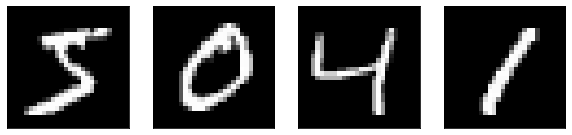

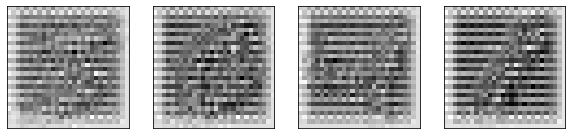

epoch 1 batch 36 batch total loss 0.23048948
epoch 1 batch 36 batch cluster loss 0.13016763
epoch 1 batch 36 batch regen loss 0.100321844
epoch 1 batch 37 batch total loss 0.23345748
epoch 1 batch 37 batch cluster loss 0.12923801
epoch 1 batch 37 batch regen loss 0.104219474
epoch 1 batch 38 batch total loss 0.23120329
epoch 1 batch 38 batch cluster loss 0.12005134
epoch 1 batch 38 batch regen loss 0.111151956
epoch 1 batch 39 batch total loss 0.23054051
epoch 1 batch 39 batch cluster loss 0.12707075
epoch 1 batch 39 batch regen loss 0.10346977
epoch 1 batch 40 batch total loss 0.23557486
epoch 1 batch 40 batch cluster loss 0.1305731
epoch 1 batch 40 batch regen loss 0.10500176
saving...



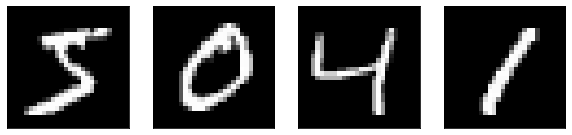

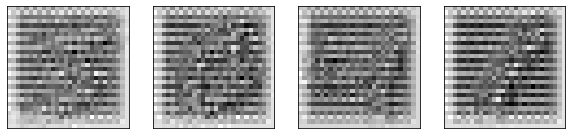

epoch 1 batch 41 batch total loss 0.23247471
epoch 1 batch 41 batch cluster loss 0.13105059
epoch 1 batch 41 batch regen loss 0.101424135
epoch 1 batch 42 batch total loss 0.23733374
epoch 1 batch 42 batch cluster loss 0.13125032
epoch 1 batch 42 batch regen loss 0.10608342
epoch 1 batch 43 batch total loss 0.23200509
epoch 1 batch 43 batch cluster loss 0.13132316
epoch 1 batch 43 batch regen loss 0.10068192
epoch 1 batch 44 batch total loss 0.24198762
epoch 1 batch 44 batch cluster loss 0.13131942
epoch 1 batch 44 batch regen loss 0.1106682
epoch 1 batch 45 batch total loss 0.23733175
epoch 1 batch 45 batch cluster loss 0.13111234
epoch 1 batch 45 batch regen loss 0.1062194
saving...



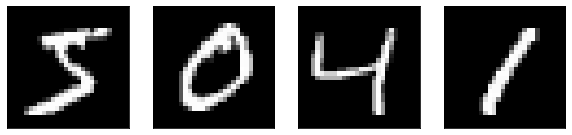

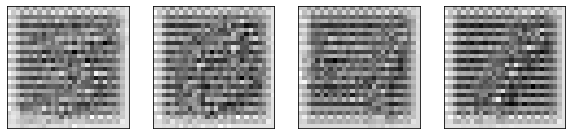

epoch 1 batch 46 batch total loss 0.23030758
epoch 1 batch 46 batch cluster loss 0.1306597
epoch 1 batch 46 batch regen loss 0.09964789
epoch 1 batch 47 batch total loss 0.22585666
epoch 1 batch 47 batch cluster loss 0.12368304
epoch 1 batch 47 batch regen loss 0.10217362
epoch 1 batch 48 batch total loss 0.23153399
epoch 1 batch 48 batch cluster loss 0.13054153
epoch 1 batch 48 batch regen loss 0.100992456
epoch 1 batch 49 batch total loss 0.23833853
epoch 1 batch 49 batch cluster loss 0.13149951
epoch 1 batch 49 batch regen loss 0.106839016
epoch 1 batch 50 batch total loss 0.22985724
epoch 1 batch 50 batch cluster loss 0.13166314
epoch 1 batch 50 batch regen loss 0.09819409
saving...



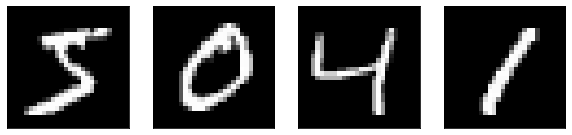

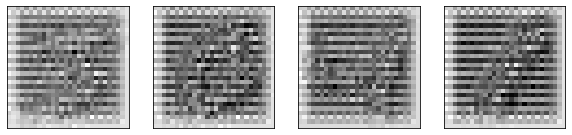

epoch 1 batch 51 batch total loss 0.22740927
epoch 1 batch 51 batch cluster loss 0.13172589
epoch 1 batch 51 batch regen loss 0.09568339
epoch 1 batch 52 batch total loss 0.23418245
epoch 1 batch 52 batch cluster loss 0.13175035
epoch 1 batch 52 batch regen loss 0.102432095
epoch 1 batch 53 batch total loss 0.2338281
epoch 1 batch 53 batch cluster loss 0.13175914
epoch 1 batch 53 batch regen loss 0.10206896
epoch 1 batch 54 batch total loss 0.23345725
epoch 1 batch 54 batch cluster loss 0.13177058
epoch 1 batch 54 batch regen loss 0.10168667
epoch 1 batch 55 batch total loss 0.24139175
epoch 1 batch 55 batch cluster loss 0.13177168
epoch 1 batch 55 batch regen loss 0.109620064
saving...



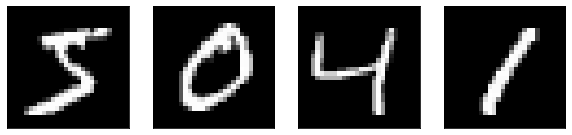

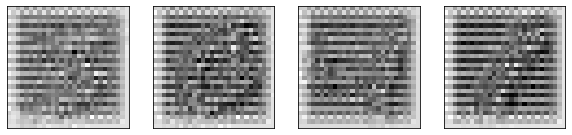

epoch 1 batch 56 batch total loss 0.23259872
epoch 1 batch 56 batch cluster loss 0.13177833
epoch 1 batch 56 batch regen loss 0.1008204
epoch 1 batch 57 batch total loss 0.23632513
epoch 1 batch 57 batch cluster loss 0.13177228
epoch 1 batch 57 batch regen loss 0.10455285
epoch 1 batch 58 batch total loss 0.2257202
epoch 1 batch 58 batch cluster loss 0.13177103
epoch 1 batch 58 batch regen loss 0.09394917
epoch 1 batch 59 batch total loss 0.22882174
epoch 1 batch 59 batch cluster loss 0.13175441
epoch 1 batch 59 batch regen loss 0.09706733
epoch 1 batch 60 batch total loss 0.2276798
epoch 1 batch 60 batch cluster loss 0.13173324
epoch 1 batch 60 batch regen loss 0.095946565
saving...



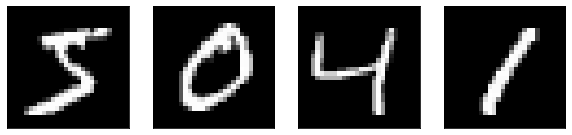

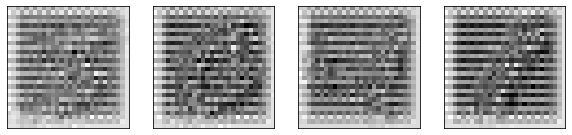

epoch 1 batch 61 batch total loss 0.22475812
epoch 1 batch 61 batch cluster loss 0.1317061
epoch 1 batch 61 batch regen loss 0.09305201
epoch 1 batch 62 batch total loss 0.23166215
epoch 1 batch 62 batch cluster loss 0.13158625
epoch 1 batch 62 batch regen loss 0.10007589
epoch 1 batch 63 batch total loss 0.23353824
epoch 1 batch 63 batch cluster loss 0.13106662
epoch 1 batch 63 batch regen loss 0.10247162
epoch 1 batch 64 batch total loss 0.21986598
epoch 1 batch 64 batch cluster loss 0.11732854
epoch 1 batch 64 batch regen loss 0.10253744
epoch 1 batch 65 batch total loss 0.22597796
epoch 1 batch 65 batch cluster loss 0.13028222
epoch 1 batch 65 batch regen loss 0.095695734
saving...



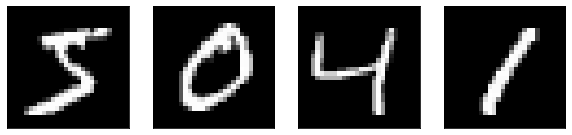

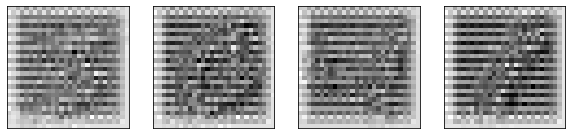

epoch 1 batch 66 batch total loss 0.23033322
epoch 1 batch 66 batch cluster loss 0.13079667
epoch 1 batch 66 batch regen loss 0.09953655
epoch 1 batch 67 batch total loss 0.22972178
epoch 1 batch 67 batch cluster loss 0.12701482
epoch 1 batch 67 batch regen loss 0.102706976
epoch 1 batch 68 batch total loss 0.23077865
epoch 1 batch 68 batch cluster loss 0.1314816
epoch 1 batch 68 batch regen loss 0.09929705
epoch 1 batch 69 batch total loss 0.23259185
epoch 1 batch 69 batch cluster loss 0.13172257
epoch 1 batch 69 batch regen loss 0.10086928
epoch 1 batch 70 batch total loss 0.23194036
epoch 1 batch 70 batch cluster loss 0.1317737
epoch 1 batch 70 batch regen loss 0.10016667
saving...



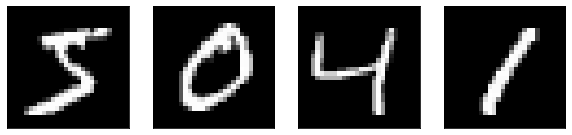

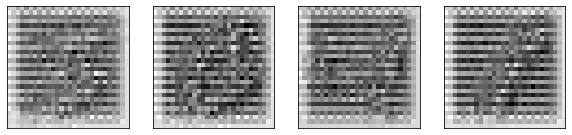

epoch 1 batch 71 batch total loss 0.24005967
epoch 1 batch 71 batch cluster loss 0.13179423
epoch 1 batch 71 batch regen loss 0.108265445
epoch 1 batch 72 batch total loss 0.23861298
epoch 1 batch 72 batch cluster loss 0.13180405
epoch 1 batch 72 batch regen loss 0.10680892
epoch 1 batch 73 batch total loss 0.2305432
epoch 1 batch 73 batch cluster loss 0.1318052
epoch 1 batch 73 batch regen loss 0.098738
epoch 1 batch 74 batch total loss 0.23011935
epoch 1 batch 74 batch cluster loss 0.13180792
epoch 1 batch 74 batch regen loss 0.098311424
epoch 1 batch 75 batch total loss 0.23159963
epoch 1 batch 75 batch cluster loss 0.13180803
epoch 1 batch 75 batch regen loss 0.09979161
saving...



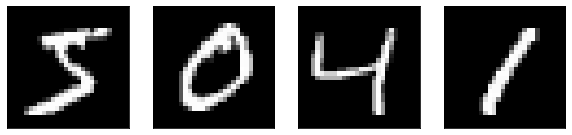

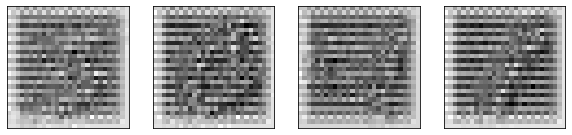

epoch 1 batch 76 batch total loss 0.23537874
epoch 1 batch 76 batch cluster loss 0.13180713
epoch 1 batch 76 batch regen loss 0.103571616
epoch 1 batch 77 batch total loss 0.23003434
epoch 1 batch 77 batch cluster loss 0.1318052
epoch 1 batch 77 batch regen loss 0.09822914
epoch 1 batch 78 batch total loss 0.2317827
epoch 1 batch 78 batch cluster loss 0.13179952
epoch 1 batch 78 batch regen loss 0.09998318
epoch 1 batch 79 batch total loss 0.2313602
epoch 1 batch 79 batch cluster loss 0.13179237
epoch 1 batch 79 batch regen loss 0.09956782
epoch 1 batch 80 batch total loss 0.23006687
epoch 1 batch 80 batch cluster loss 0.13177317
epoch 1 batch 80 batch regen loss 0.09829369
saving...



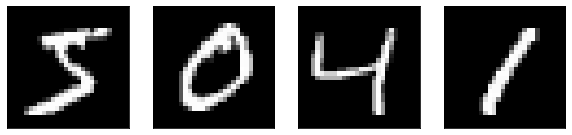

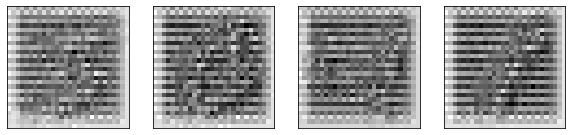

epoch 1 batch 81 batch total loss 0.22631866
epoch 1 batch 81 batch cluster loss 0.13173929
epoch 1 batch 81 batch regen loss 0.09457938
epoch 1 batch 82 batch total loss 0.23409754
epoch 1 batch 82 batch cluster loss 0.13150272
epoch 1 batch 82 batch regen loss 0.10259483
epoch 1 batch 83 batch total loss 0.18409479
epoch 1 batch 83 batch cluster loss 0.08170347
epoch 1 batch 83 batch regen loss 0.10239132
epoch 1 batch 84 batch total loss 0.23129186
epoch 1 batch 84 batch cluster loss 0.13181323
epoch 1 batch 84 batch regen loss 0.099478625
epoch 1 batch 85 batch total loss 0.2278336
epoch 1 batch 85 batch cluster loss 0.13182846
epoch 1 batch 85 batch regen loss 0.096005134
saving...



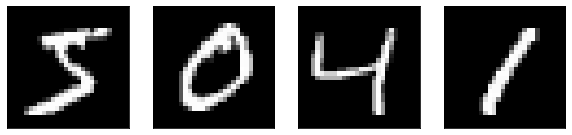

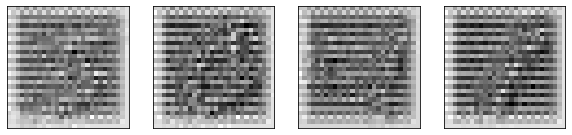

epoch 1 batch 86 batch total loss 0.22875756
epoch 1 batch 86 batch cluster loss 0.13183141
epoch 1 batch 86 batch regen loss 0.096926145
epoch 1 batch 87 batch total loss 0.22856918
epoch 1 batch 87 batch cluster loss 0.13183238
epoch 1 batch 87 batch regen loss 0.09673681
epoch 1 batch 88 batch total loss 0.22888094
epoch 1 batch 88 batch cluster loss 0.13183321
epoch 1 batch 88 batch regen loss 0.097047724
epoch 1 batch 89 batch total loss 0.22493456
epoch 1 batch 89 batch cluster loss 0.13183382
epoch 1 batch 89 batch regen loss 0.09310074
epoch 1 batch 90 batch total loss 0.22729616
epoch 1 batch 90 batch cluster loss 0.13183418
epoch 1 batch 90 batch regen loss 0.09546198
saving...



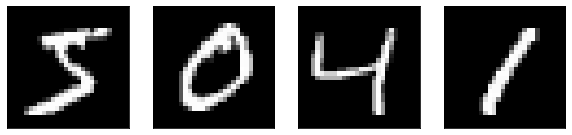

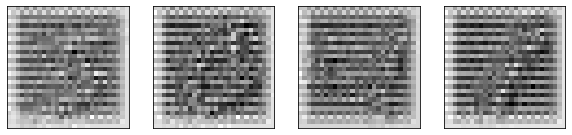

epoch 1 batch 91 batch total loss 0.23389667
epoch 1 batch 91 batch cluster loss 0.13183409
epoch 1 batch 91 batch regen loss 0.102062576
epoch 1 batch 92 batch total loss 0.22980788
epoch 1 batch 92 batch cluster loss 0.13183437
epoch 1 batch 92 batch regen loss 0.09797351
epoch 1 batch 93 batch total loss 0.23802504
epoch 1 batch 93 batch cluster loss 0.13183439
epoch 1 batch 93 batch regen loss 0.10619066
epoch 1 batch 94 batch total loss 0.23929904
epoch 1 batch 94 batch cluster loss 0.13183452
epoch 1 batch 94 batch regen loss 0.10746452
epoch 1 batch 95 batch total loss 0.2299135
epoch 1 batch 95 batch cluster loss 0.13183467
epoch 1 batch 95 batch regen loss 0.09807884
saving...



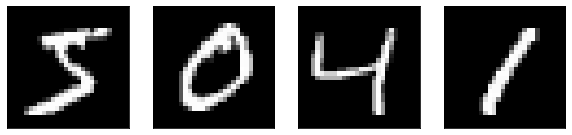

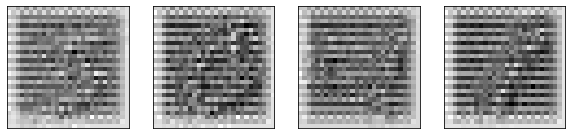

epoch 1 batch 96 batch total loss 0.23055364
epoch 1 batch 96 batch cluster loss 0.13183469
epoch 1 batch 96 batch regen loss 0.098718956
epoch 1 batch 97 batch total loss 0.22687835
epoch 1 batch 97 batch cluster loss 0.13183475
epoch 1 batch 97 batch regen loss 0.09504359
epoch 1 batch 98 batch total loss 0.22710359
epoch 1 batch 98 batch cluster loss 0.13183482
epoch 1 batch 98 batch regen loss 0.09526877
epoch 1 batch 99 batch total loss 0.23268297
epoch 1 batch 99 batch cluster loss 0.13183492
epoch 1 batch 99 batch regen loss 0.10084804
epoch 1 batch 100 batch total loss 0.23391236
epoch 1 batch 100 batch cluster loss 0.13183482
epoch 1 batch 100 batch regen loss 0.102077544
saving...



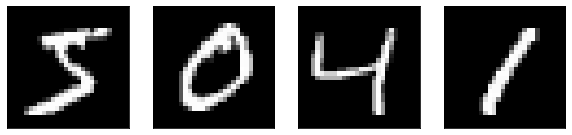

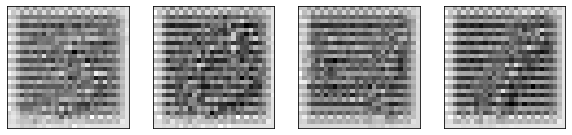

epoch 1 batch 101 batch total loss 0.22418043
epoch 1 batch 101 batch cluster loss 0.13183498
epoch 1 batch 101 batch regen loss 0.09234544
epoch 1 batch 102 batch total loss 0.22872941
epoch 1 batch 102 batch cluster loss 0.13183501
epoch 1 batch 102 batch regen loss 0.0968944
epoch 1 batch 103 batch total loss 0.23138598
epoch 1 batch 103 batch cluster loss 0.13183504
epoch 1 batch 103 batch regen loss 0.099550925
epoch 1 batch 104 batch total loss 0.22594675
epoch 1 batch 104 batch cluster loss 0.131835
epoch 1 batch 104 batch regen loss 0.094111755
epoch 1 batch 105 batch total loss 0.22689989
epoch 1 batch 105 batch cluster loss 0.131835
epoch 1 batch 105 batch regen loss 0.0950649
saving...



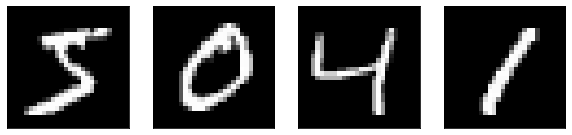

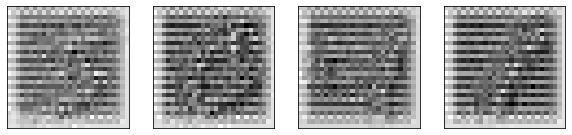

epoch 1 batch 106 batch total loss 0.23346159
epoch 1 batch 106 batch cluster loss 0.13183509
epoch 1 batch 106 batch regen loss 0.10162649
epoch 1 batch 107 batch total loss 0.23117933
epoch 1 batch 107 batch cluster loss 0.13183495
epoch 1 batch 107 batch regen loss 0.099344365
epoch 1 batch 108 batch total loss 0.23632056
epoch 1 batch 108 batch cluster loss 0.13183501
epoch 1 batch 108 batch regen loss 0.10448555
epoch 1 batch 109 batch total loss 0.23029321
epoch 1 batch 109 batch cluster loss 0.131835
epoch 1 batch 109 batch regen loss 0.09845822
epoch 1 batch 110 batch total loss 0.2288299
epoch 1 batch 110 batch cluster loss 0.13183495
epoch 1 batch 110 batch regen loss 0.09699495
saving...



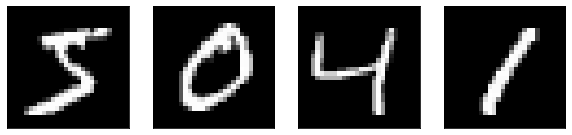

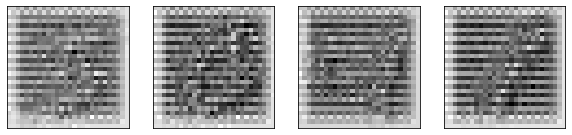

epoch 1 batch 111 batch total loss 0.22591151
epoch 1 batch 111 batch cluster loss 0.13183506
epoch 1 batch 111 batch regen loss 0.094076455
epoch 1 batch 112 batch total loss 0.2257858
epoch 1 batch 112 batch cluster loss 0.13183507
epoch 1 batch 112 batch regen loss 0.09395073
epoch 1 batch 113 batch total loss 0.22590753
epoch 1 batch 113 batch cluster loss 0.13183509
epoch 1 batch 113 batch regen loss 0.09407244
epoch 1 batch 114 batch total loss 0.22389176
epoch 1 batch 114 batch cluster loss 0.131835
epoch 1 batch 114 batch regen loss 0.09205676
epoch 1 batch 115 batch total loss 0.2344912
epoch 1 batch 115 batch cluster loss 0.131835
epoch 1 batch 115 batch regen loss 0.10265621
saving...



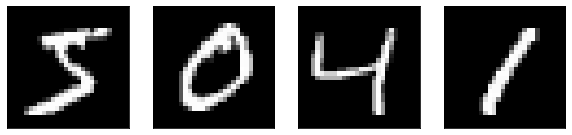

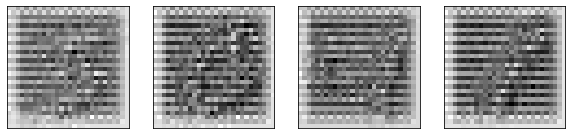

epoch 1 batch 116 batch total loss 0.24003404
epoch 1 batch 116 batch cluster loss 0.13183512
epoch 1 batch 116 batch regen loss 0.108198926
epoch 1 batch 117 batch total loss 0.78952765
epoch 1 batch 117 batch cluster loss 0.70312166
epoch 1 batch 117 batch regen loss 0.086406

epoch 1 epoch avg loss 0.23678533404560412
epoch 1 epoch avg cluster loss 0.1351877002013942
epoch 1 epoch avg regen loss 0.10159763365478838



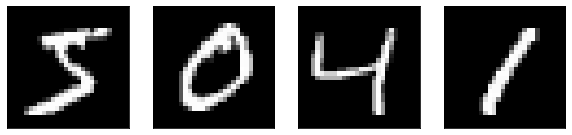

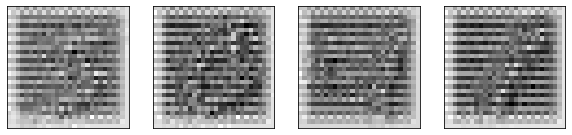

saving...

epoch 2
epoch 2 batch 0 batch total loss 0.22735673
epoch 2 batch 0 batch cluster loss 0.13183504
epoch 2 batch 0 batch regen loss 0.09552169
saving...



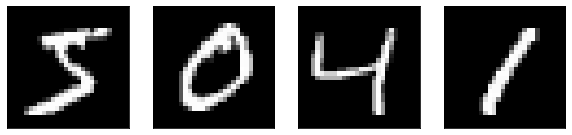

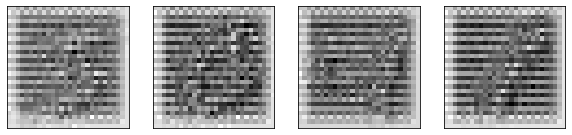

epoch 2 batch 1 batch total loss 0.22978964
epoch 2 batch 1 batch cluster loss 0.13183506
epoch 2 batch 1 batch regen loss 0.097954586
epoch 2 batch 2 batch total loss 0.23426902
epoch 2 batch 2 batch cluster loss 0.13183507
epoch 2 batch 2 batch regen loss 0.10243394
epoch 2 batch 3 batch total loss 0.23012981
epoch 2 batch 3 batch cluster loss 0.13183492
epoch 2 batch 3 batch regen loss 0.09829488


In [ ]:
# model = AE(embedding_dim)
# model.load_state_dict(torch.load('/content/gdrive/My Drive/mean shift data/ms_ae_shift.pt'))
# model = model.cuda()

epoch_avg_total_loss = [0]*total_epochs

epoch_avg_cluster_loss = [0]*total_epochs

epoch_avg_regen_loss = [0]*total_epochs

total_loss_win = vis.line(
    Y=np.zeros((1)),
    X=np.zeros((1)),
    opts=dict(xlabel='epoch',title='Regen MS 3',ylabel='Total Loss',legend=['Loss']))

cluster_loss_win = vis.line(
    Y=np.zeros((1)),
    X=np.zeros((1)),
    opts=dict(xlabel='epoch',title='Regen MS 3',ylabel='Cluster Loss',legend=['Loss']))

regen_loss_win = vis.line(
    Y=np.zeros((1)),
    X=np.zeros((1)),
    opts=dict(xlabel='epoch',title='Regen MS 3',ylabel='Regen Loss',legend=['Loss']))

for epoch in range(total_epochs):
  
    print('epoch', epoch)
  
    avg_total_loss = 0
    avg_cluster_loss = 0
    avg_regen_loss = 0
    total_batches = 0
    
    for batch_idx, (x, target) in enumerate(train_loader):
        
        x, target = x.cuda(), target.numpy()

        x_, z = model(x)
        
        clust_embs = ms_clust(z.t()) 
        
        total_loss, cluster_loss, regen_loss = ms_ae_loss(x, x_, clust_embs, target)
    
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
        print('epoch', epoch, 'batch', batch_idx, 'batch total loss', total_loss.cpu().detach().numpy())
        print('epoch', epoch, 'batch', batch_idx, 'batch cluster loss', cluster_loss.cpu().detach().numpy())
        print('epoch', epoch, 'batch', batch_idx, 'batch regen loss', regen_loss.cpu().detach().numpy())
    
        avg_total_loss += total_loss.cpu().detach().numpy()
        avg_cluster_loss += cluster_loss.cpu().detach().numpy()
        avg_regen_loss += regen_loss.cpu().detach().numpy()
    
        if batch_idx % 5 == 0:
            print('saving...')
            torch.save(model.state_dict(), '/home/ankitas/btp_mean_shift/save/regen_shift_3.pt')
            print()
            plot_regen(model)
    
        total_batches += 1
   
    epoch_avg_total_loss[epoch] = avg_total_loss/total_batches
    epoch_avg_cluster_loss[epoch] = avg_cluster_loss/total_batches
    epoch_avg_regen_loss[epoch] = avg_regen_loss/total_batches
  
    loss_file = open('/home/ankitas/btp_mean_shift/save/loss_list_regen_shift_3.pkl', 'wb+')
    pickle.dump([epoch_avg_total_loss, epoch_avg_cluster_loss, epoch_avg_regen_loss], loss_file)
#     pickle.dump(epoch_avg_total_loss, loss_file)
    loss_file.close()
  
    print()
    print('epoch', epoch, 'epoch avg loss', epoch_avg_total_loss[epoch])
    print('epoch', epoch, 'epoch avg cluster loss', epoch_avg_cluster_loss[epoch])
    print('epoch', epoch, 'epoch avg regen loss', epoch_avg_regen_loss[epoch])
    print()

    vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_total_loss[epoch]]),win=total_loss_win,update='append')
    vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_cluster_loss[epoch]]),win=cluster_loss_win,update='append')
    vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_regen_loss[epoch]]),win=regen_loss_win,update='append')
    plot_regen(model)
    print('saving...')
    torch.save(model.state_dict(), '/home/ankitas/btp_mean_shift/save/regen_shift_3.pt')
    print()
 
  

# Cluster w/o mean shift

## Load Model

In [ ]:
embedding_dim=64
model=AE(embedding_dim)
model.load_state_dict(torch.load('/content/gdrive/My Drive/mean shift data/ms_ae_shift.pt'))
model = model.cuda()

## Load Data

In [ ]:
train_batch_size = 600
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=train_batch_size,
                 shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=test_batch_size,
                shuffle=False)

print ('total trainning batch number: '+ str(len(train_loader)))
print ('total testing batch number: '+ str(len(test_loader)))

## Append embeddings

In [ ]:
embeds = 0
labels = 0

for batch_idx, (x, target) in enumerate(train_loader):
          
  x, target = x.cuda(), target.numpy()
  x_, z = model(x)
  z = z.cpu().detach().numpy()
  
  if batch_idx == 0:
    labels = target
    embeds = z
  
  else:  
    embeds = np.append(embeds, z, axis=0)
    labels = np.append(labels, target, axis=0)

# for batch_idx, (x, target) in enumerate(train_loader):
        
#   x, target = x.cuda(), target.numpy()
#   x_, z = model(x)
#   z = z.cpu().detach().numpy()
  
#   embeds = np.append(embeds, z, axis=0)
#   labels = np.append(labels, target, axis=0)

print(embeds.shape)
print(labels.shape)

f = open('/content/gdrive/My Drive/mean shift data/shift_embeds.pkl', 'wb+')
pickle.dump(embeds, f)
f.close()

f = open('/content/gdrive/My Drive/mean shift data/shift_labels.pkl', 'wb+')
pickle.dump(labels, f)
f.close()

## t-SNE 

In [ ]:
from sklearn.manifold import TSNE

t_sne = TSNE(n_components=2)

X = t_sne.fit_transform(embeds)

print(X.shape)

f = open('/content/gdrive/My Drive/mean shift data/tsne_shift_20.pkl', 'wb+')
pickle.dump(X, f)
f.close()

## Plot Scatter

In [ ]:
import matplotlib.cm as cm

x = 1

cs = [i+x+(i*x)**2 for i in range(10)]

colors = cm.rainbow(np.linspace(0, 1, len(cs)))
plt.figure(figsize=(20,10))
for i, c in enumerate(colors):
  plt.scatter(X[labels==i][:, 0], X[labels==i][:, 1], c=c, s=20, edgecolors='k', label=i+1)
plt.legend()
plt.show()